<a href="https://colab.research.google.com/github/mikolaj553/Machine-Learning-Homeworks-Repo/blob/main/ml_hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Homework #3 - Mikołaj Kowalewski, lab group no. 1**


Let us start off with presenting the dataset we will use for the analysis. We use the Breast Cancer Wisconsin (Diagnostic) dataset from scikit-learn, which contains 569 examples of tumor samples, each sample has 30 features. The target variable indicates whether a tumor is malignant (cancerous) or benign (non-cancerous), so it is a 2-class dataset. There are 212 malignant cases and 357 benign cases, so about 37% of the samples are positive (malignant). We split the data into training, validation, and test sets with the following proportions: 60% train, 20% validation, 20% test using train_test_split with stratification to preserve class proportions.

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

data = load_breast_cancer()
X, y = data.data, data.target

# In the loaded data, target 0 = malignant, 1 = benign. Inverting so that 1 = malignant (positive class), 0 = benign.
y = 1 - y

# Stratified split into train (60%), temp (40%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# Further split into validation (20%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

print("Train size:", X_train.shape[0], " | Malignant:", sum(y_train), "Benign:", len(y_train)-sum(y_train))
print("Validation size:", X_val.shape[0], " | Malignant:", sum(y_val), "Benign:", len(y_val)-sum(y_val))
print("Test size:", X_test.shape[0], " | Malignant:", sum(y_test), "Benign:", len(y_test)-sum(y_test))


Train size: 341  | Malignant: 127 Benign: 214
Validation size: 114  | Malignant: 43 Benign: 71
Test size: 114  | Malignant: 42 Benign: 72


Next, we create a logistic regression model to classify the tumors as either malignant or benign. We train the model on the training set.


In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train_scaled, y_train)


LogisticRegression(random_state=42, solver='liblinear')

After training, we evaluate the model on the validation set to analyze its performance at different thresholds. First, we obtain the predicted probabilities for the positive class (malignant) on the validation data. Using these probabilities and the true labels, we compute the ROC curve and the AUC. The ROC curve plots the True Positive Rate (Sensitivity) against the False Positive Rate (1 − Specificity) for all possible threshold values. We also determine an "optimal" threshold from the ROC curve – here we choose the threshold that maximizes the sum of sensitivity and specificity (equivalently, the point closest to the top-left of the ROC plot).

In [8]:
from sklearn.metrics import roc_curve, roc_auc_score

# Scaling the validation data using the same scaler used for the training set
X_val_scaled = scaler.transform(X_val)

# Predicting probabilities for the validation set
y_val_proba = model.predict_proba(X_val_scaled)[:, 1]  # probability of class 1 (malignant)

# Computing ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
val_auc = roc_auc_score(y_val, y_val_proba)

# Finding the threshold that maximizes (sensitivity + specificity - 1)
val_index = tpr - fpr
opt_idx = val_index.argmax()
opt_threshold = thresholds[opt_idx]

print(f"Validation AUC: {val_auc:.3f}")
print(f"Optimal threshold on validation: {opt_threshold:.3f}")
print(f"Sensitivity at optimal threshold: {tpr[opt_idx]:.3f}, Specificity: {1 - fpr[opt_idx]:.3f}")



Validation AUC: 0.996
Optimal threshold on validation: 0.926
Sensitivity at optimal threshold: 0.977, Specificity: 1.000


Now, let's visualize the ROC curve for the validation set and mark the optimal threshold point:

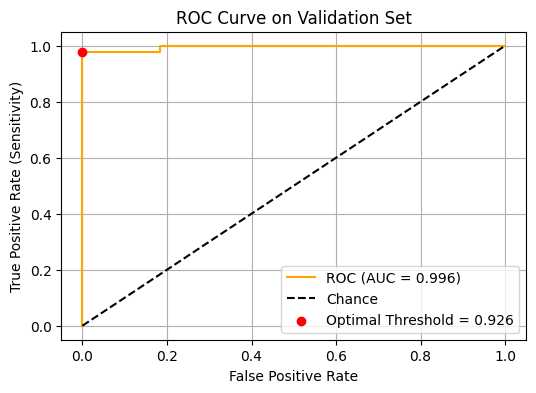

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC (AUC = {val_auc:.3f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.scatter(fpr[opt_idx], tpr[opt_idx], color='red', zorder=10, label=f'Optimal Threshold = {opt_threshold:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve on Validation Set')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


The orange line shows the model's ROC curve (AUC ≈ 0.996, which indicates excellent performance on the validation set). The red dot marks the point corresponding to the optimal threshold (around 0.926) which maximizes the sum of sensitivity and specificity. At this point, the True Positive Rate is about 0.98 (98% sensitivity) and the False Positive Rate is near 0 (≈0% false alarms on validation). Let us now evaluate the model on the test set using two threshold values to decide class labels: the standard 0.5 (≥0.5 as malignant, <0.5 as benign) and 0.926 from the ROC curve.

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def evaluate_threshold(y_true, y_proba, threshold):
    """Return evaluation metrics given true labels and predicted probabilities at a specific threshold."""
    y_pred = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, specificity, f1, tp, fp, tn, fn

# Scale the test set using the same scaler from training
X_test_scaled = scaler.transform(X_test)

# Predicted probabilities on the test set
y_test_proba = model.predict_proba(X_test_scaled)[:, 1]

# Evaluate at default threshold 0.5
acc_0_5, prec_0_5, rec_0_5, spec_0_5, f1_0_5, TP_0_5, FP_0_5, TN_0_5, FN_0_5 = evaluate_threshold(y_test, y_test_proba, 0.5)

# Evaluate at optimal threshold (from validation)
acc_opt, prec_opt, rec_opt, spec_opt, f1_opt, TP_opt, FP_opt, TN_opt, FN_opt = evaluate_threshold(y_test, y_test_proba, opt_threshold)

print(f"Threshold 0.5 -> Accuracy: {acc_0_5:.3f}, Precision: {prec_0_5:.3f}, "
      f"Sensitivity: {rec_0_5:.3f}, Specificity: {spec_0_5:.3f}, F1-Score: {f1_0_5:.3f}")
print(f"Threshold {opt_threshold:.3f} -> Accuracy: {acc_opt:.3f}, Precision: {prec_opt:.3f}, "
      f"Sensitivity: {rec_opt:.3f}, Specificity: {spec_opt:.3f}, F1-Score: {f1_opt:.3f}")
print(f"Confusion Matrix at 0.5: TP={TP_0_5}, FP={FP_0_5}, TN={TN_0_5}, FN={FN_0_5}")
print(f"Confusion Matrix at {opt_threshold:.3f}: TP={TP_opt}, FP={FP_opt}, TN={TN_opt}, FN={FN_opt}")


Threshold 0.5 -> Accuracy: 0.974, Precision: 0.976, Sensitivity: 0.952, Specificity: 0.986, F1-Score: 0.964
Threshold 0.926 -> Accuracy: 0.921, Precision: 1.000, Sensitivity: 0.786, Specificity: 1.000, F1-Score: 0.880
Confusion Matrix at 0.5: TP=40, FP=1, TN=71, FN=2
Confusion Matrix at 0.926: TP=33, FP=0, TN=72, FN=9


Looking at the above results, it can be seen that at the default threshold of 0.5, the model correctly identifies about 95.2% of malignant cases (sensitivity 0.952) while maintaining a specificity of 98.6% (only 1 False Positive, meaning just 1 benign case was incorrectly classified as malignant). Using the higher threshold of 0.926 (chosen from validation based on the ROC curve), the model exhibits different behavior: it flags fewer cases as malignant. This yields perfect specificity (1.000 – zero false positives on the test set) but sensitivity drops to ~78.6%, meaning several malignant cases were missed. The precision at 0.93 is 100% (every detected positive is truly malignant, since there are no false positives), whereas at 0.5 precision was ~97.6% with one false alarm.

**Discussion**

**1. Would a different threshold yield better results?**

**Answer:** It depends – adjusting the decision threshold can yield "better" results for specific metrics or objectives, but often at the expense of others. In our example, using a threshold higher than 0.5 (in our case, 0.926) made the model more strict about labeling malignancy. This virtually eliminated false positives (increasing specificity and precision, which is worse if false alarms are costly) but also caused more missed cancers (decreasing sensitivity, which is worse if missing positives is critical). Conversely, a lower threshold would catch more malignancies (better sensitivity) but produce more false positives (lower specificity). Therefore, a different threshold can improve certain aspects of performance, but it introduces a trade-off – what improves will come at the cost of a decrease in something else.


**2. How do you define "better" results?**

**Answer:** “Better” depends on which errors matter most in a given context. In the context of breast cancer detection, which is the dataset we have been working with, “better” often means minimizing false negatives to ensure malignant cases are not missed, so higher sensitivity is typically essential. Conversely, for spam filtering, avoiding false alarms (i.e., higher specificity) can be more important because flagging legitimate messages as spam can cause significant loss of important information, communication errors, etc.  Ultimately, the best threshold depends on these domain-specific trade-offs, so one should decide which metric (sensitivity, specificity, precision, etc.) is the most important. In our case, in a real-world scenario, between the two threshold settings (0.5 and ~0.93), the model using the lower threshold (0.5) would generally be more applicable for breast cancer detection. In most medical contexts, it is riskier to miss malignant cases (false negatives) than to classify benign cases as suspicious (false positives). The latter might cause some stress for the patients, but it is generally better to conduct a few follow-up tests than to miss dangerous cases entirely.


**3. How does a ROC curve help in this process?**

**Answer:** The ROC curve visually shows how sensitivity and specificity change across all possible thresholds. It plots the true positive rate (sensitivity) against the false positive rate (1 − specificity), thus allowing one to see this trade-off between these two in a single graph. In our analysis, the curve highlighted that our model could achieve very high sensitivity with minimal false positives on the validation set, and it also helped us identify an “optimal” threshold (~0.93) by maximizing (sensitivity + specificity − 1). This gave us a clear view of how different threshold choices, from 0.5 to 0.926, would impact performance for breast cancer detection.


**4. How do you select the optimal threshold using the ROC curve?**

**Answer:** We typically select the optimal threshold on the ROC curve by looking for a point that balances sensitivity and specificity in a way that suits our needs in the context of the task at hand. In our analysis, we used Youden’s J statistic (sensitivity + specificity − 1) to identify 0.926 as the threshold that best balanced these metrics on the validation set. However, other methods of choosing that threshold can be employed. For instance, we could impose a constraint (e.g., sensitivity ≥ 95%) and choose the threshold on the ROC curve that meets this requirement while maximizing specificity.

**5. What is the AUC metric and how is it useful?**

**Answer:** The AUC (Area Under the ROC Curve) measures a model’s overall ability to discriminate between classes across all possible decision thresholds. In our analysis, the logistic regression model achieved an AUC of 0.996 on the validation set, indicating near-perfect separation of malignant and benign tumors. An AUC of 1.0 would mean the model always ranks positive cases higher than negative cases, whereas 0.5 is no better than random guessing. The AUC is useful because it captures the model’s performance across all thresholds, rather than at a fixed threshold. This makes it especially handy for comparing models: a model with higher AUC will generally perform better in classification (for some threshold) than one with lower AUC, regardless of the exact threshold chosen. In our case, the logistic regression achieved an AUC of ~0.996 on the validation set, which is extremely high – it means the model almost perfectly distinguishes malignant from benign cases. This indicates that the model will provide mostly accurate predictions no matter the threshold - but tuning the threshold can make the model "better" in terms of some trade-offs, as seen earlier in the case of our analysis.